# Gated_Recurrent_Unit

* Compared with Rated Recurrent Unit (RRU), Gated Recurrent Unit (GRU) simple adds one more gate and more parameters, which make the model more expressive than that of RRU.
* In terms of code, writing GRU should be relatively trivial if you already understand the simple recurrent unit and RRU. We just need to add more weights and modify the recurrence function. 

## Modularization

* Since Rated recurrent unit, gated recurrent unit and LSTM are different ways to architect the recurrent net unit, we can treat the recurrent unit as a black box and modularize it. Thus, we can plug-in different recurrent unit as needed.
* In this notebook, we will create a Gated Recurrent Unit class that can be reused by recurrent net work

In [86]:
import sys
import theano
import theano.tensor as T
import numpy as np
import string
import matplotlib.pyplot as plt
import json
import nltk
import operator
from nltk import pos_tag, word_tokenize
from sklearn.utils import shuffle
from datetime import datetime
from nltk.corpus import brown

In [76]:
nltk.download('brown')

[nltk_data] Downloading package brown to /Users/yankang/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [11]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [93]:
class GRU(object):
    def __init__(self, Mi, Mo, activation):
        self.Mi = Mi
        self.Mo = Mo
        self.f = activation
        
        W_xr = init_weight(Mi, Mo)
        W_hr = init_weight(Mo, Mo)
        br = np.zeros(Mo)
        
        W_xz = init_weight(Mi, Mo)
        W_hz = init_weight(Mo, Mo)
        bz = np.zeros(Mo)
        
        W_xh = init_weight(Mi, Mo)
        W_hh = init_weight(Mo, Mo)
        bh = np.zeros(Mo)
        h0 = np.zeros(Mo)
        
        self.W_xr = theano.shared(W_xr)
        self.W_hr = theano.shared(W_hr)
        self.br = theano.shared(br)
        
        self.W_xz = theano.shared(W_xz)
        self.W_hz = theano.shared(W_hz)
        self.bz = theano.shared(bz)
        
        self.W_xh = theano.shared(W_xh)
        self.W_hh = theano.shared(W_hh)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        
        self.params = [self.W_xr, self.W_hr, self.br, self.W_xz, self.W_hz, self.bz, self.W_xh, 
                       self.W_hh, self.bh, self.h0]
        
    def recurrence(self, x_t, h_t1):
        z_t = T.nnet.sigmoid(x_t.dot(self.W_xz) + h_t1.dot(self.W_hz) + self.bz)
        r_t = T.nnet.sigmoid(x_t.dot(self.W_xr) + h_t1.dot(self.W_hr) + self.br)
        h_hat_t = self.f(x_t.dot(self.W_xh) + (r_t * h_t1).dot(self.W_hh) + self.bh)
        h_t = (1 - z_t) * h_t1 + z_t * h_hat_t
        return h_t
    
    def output(self, X):
        h, _ = theano.scan(
                fn=self.recurrence,
                sequences=X,
                outputs_info=[self.h0],
                n_steps=X.shape[0],
        )
        return h
        

In [94]:
class RNN(object):
    def __init__(self, D, hidden_layer_sizes, V):
        self.V = V
        self.D = D
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def fit(self, X, learning_rate=1e-5, mu=0.99, epochs=10, activation=T.nnet.relu, show_fig=True, 
            RecurrentUnit=GRU, normalize=True):
        
        V = self.V
        D = self.D
        N = len(X)
        
        ### initialize hidden layers (i.e., recurrent units)
            
        self.hidden_layers = []
        Mi = D
        for Mo in self.hidden_layer_sizes:
            ru = RecurrentUnit(Mi, Mo, activation)
            self.hidden_layers.append(ru)
            Mi = Mo
        
        ### initialize weights for word embedding layer and output layer
                
        We = init_weight(V, D)
        Wo = init_weight(Mi, V)
        bo = np.zeros(V)
        
        self.We = theano.shared(We)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.Wo, self.bo]
        for ru in self.hidden_layers:
            self.params += ru.params
        
        ### create input training vectors
        
        thx = T.ivector('X')
        thy = T.ivector('Y')
        
        ### forward propagation
        
        Z = self.We[thx]
        for ru in self.hidden_layers:
            Z = ru.output(Z)
            
        py_x = T.nnet.softmax(Z.dot(self.Wo) + self.bo)
        
        prediction = T.argmax(py_x, axis=1)
        self.prediction_op = theano.function(
            inputs=[thx],
            outputs=[py_x, prediction],
            allow_input_downcast=True,
        )
        
        ### back propagation
        
        cost = -T.mean(T.log(py_x[T.arange(thy.shape[0]), thy]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        
        gWe = T.grad(cost, self.We)
        dWe = theano.shared(self.We.get_value()*0)
        dWe_update = mu*dWe - learning_rate*gWe
        We_update = self.We + dWe_update
        
        # normalize other parameters???
        if normalize:
            We_update /= We_update.norm(2)
        
        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(self.dparams, grads)
        ] + [
            (self.We, We_update), (dWe, dWe_update)
        ]
        
        self.train_op = theano.function(
            inputs=[thx, thy],
            outputs=[cost, prediction],
            updates=updates,
        )
        
        ### training
        costs=[]
        for i in range(epochs):
            t0 = datetime.now()
            X = shuffle(X)
            cost=0
            n_correct=0
            n_total=0
            
            for j in range(N):
                if np.random.random() < 0.01 or len(X[j]) <=1:
                    input_sequence = [0] + X[j]
                    output_sequence = X[j] + [1]
                else:
                    input_sequence = [0] + X[j][:-1]
                    output_sequence = X[j]
                n_total += len(output_sequence)
                
                try:
                    c, p = self.train_op(input_sequence, output_sequence)
                except Exception as e:
                    py_x, pred = self.prediction_op(input_sequence)
                    print("input_sequence len:", len(input_sequence))
                    print("py_x.shape", py_x.shape)
                    print("pred.shape", pred.shape)
                    raise e
                cost+=c
                for pj, xj in zip(p, output_sequence):
                    if pj == xj:
                        n_correct+=1
                
                if j % 200 == 0:
                    sys.stdout.write("j/N: %d/%d correct rate so far: %f\r" % (j, N, float(n_correct)/n_total))
                    sys.stdout.flush()
            print("i:", i, "cost:", cost, "correct rate:", (float(n_correct)/n_total), "time for epoch:", (datetime.now() - t0))
            costs.append(cost)
        
        
        if show_fig:
            plt.plot(costs)
            plt.show()    
        

In [79]:
KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])

In [89]:
def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, keep_words=KEEP_WORDS):
    sentences = brown.sents()
    indexed_sentences = []

    i = 2
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']

    word_idx_count = {
        0: float('inf'),
        1: float('inf'),
    }

    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                idx2word.append(token)
                word2idx[token] = i
                i += 1

            # keep track of counts for later sorting
            idx = word2idx[token]
            word_idx_count[idx] = word_idx_count.get(idx, 0) + 1
            indexed_sentence.append(idx)
        indexed_sentences.append(indexed_sentence)

    # restrict vocab size

    # set all the words I want to keep to infinity
    # so that they are included when I pick the most
    # common words
    for word in keep_words:
        word_idx_count[word2idx[word]] = float('inf')

    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
#         print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    word2idx_small['UNKNOWN'] = new_idx 
    unknown_idx = new_idx

    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    for word in keep_words:
        assert(word in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in indexed_sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown_idx for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

In [72]:
def get_sentences_with_word2idx():
    sentences = brown.sents()
    indexed_sentences = []

    i = 2
    word2idx = {'START': 0, 'END': 1}
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                word2idx[token] = i
                i += 1
            indexed_sentence.append(word2idx[token])
        indexed_sentences.append(indexed_sentence)

    return indexed_sentences, word2idx

In [90]:
# sentences, word2idx = get_sentences_with_word2idx()
sentences, word2idx = get_sentences_with_word2idx_limit_vocab()
print("finished retrieving data")
print("vocab size", len(word2idx), "number of sentences:", len(sentences))


finished retrieving data
vocab size 2001 number of sentences: 57013


i: 0 cost: 324226.92534 correct rate: 0.2080931524446576 time for epoch: 0:05:54.758894
i: 1 cost: 280406.053249 correct rate: 0.2081783554435123 time for epoch: 0:05:27.822977
i: 2 cost: 277492.032165 correct rate: 0.20818283651805403 time for epoch: 0:05:47.327973
i: 3 cost: 275133.250279 correct rate: 0.20492449746775063 time for epoch: 0:05:49.119582
i: 4 cost: 272193.090854 correct rate: 0.20325882940437037 time for epoch: 0:05:49.083675
i: 5 cost: 269022.677996 correct rate: 0.20658043829407652 time for epoch: 0:05:34.564550
i: 6 cost: 266469.985048 correct rate: 0.20977401917987026 time for epoch: 5:52:40.614863
i: 7 cost: 264251.408675 correct rate: 0.2121279437101403 time for epoch: 0:09:43.934519
i: 8 cost: 262708.943625 correct rate: 0.21398880041877893 time for epoch: 0:05:28.583144
i: 9 cost: 261598.872736 correct rate: 0.21477322528346302 time for epoch: 0:07:04.629615
i: 10 cost: 260789.48436 correct rate: 0.21581127039476516 time for epoch: 0:06:15.671608
i: 11 cost: 26

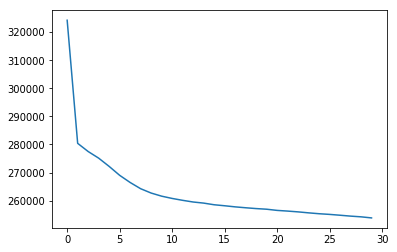

In [96]:
V = len(word2idx)
rnn = RNN(50, [50], V)
rnn.fit(sentences, learning_rate=1e-5, show_fig=True, activation=T.nnet.relu, epochs=30)  

we_file = "word_embeddings.npy"
w2i_file = "wikipedia_word2idx.json"
np.save(we_file, rnn.We.get_value())
with open(w2i_file, 'w') as f:
    json.dump(word2idx, f)

In [16]:
def find_analogies(w1, w2, w3):
    We = np.load(we_file)
    with open(w2i_file) as f:
        word2idx = json.load(f)

    kind = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]

    v0 = king - man + woman
    
    def dist1(x, y):
        return np.linalg.norm(a-b)
    
    def dist2(x, y):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
    for dist, name in [(dist1, "Euclidean"), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for word, idx in word2idx.iterms():
            if word not in (w1, w2, w3):
                v1 = We[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print("the closet match by", name, "distance:", best_word)
        print(w1, "-", w2, "=", best_word, "-", w3)


In [ ]:
find_analogies("king", "man", "woman")
find_analogies("france", "paris", "london")
find_analogies("paris", "france", "italy")